In [1]:
import os
import numpy as np
from PIL import Image, ImageFilter
import cv2
import torch,torchvision
import torchvision.transforms as transforms
from torchvision import datasets
import torch.optim as optim
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from sklearn.preprocessing import label_binarize
from itertools import cycle
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
def load_data(path, test_split, val_split, batch_size, input_size):
    
    transform_dict = {'src':transforms.Compose([transforms.RandomHorizontalFlip(),
                                                transforms.Resize((224,224)),
                                                transforms.RandomVerticalFlip(),
                                                transforms.RandomRotation(15),
                                                transforms.ToTensor(),
                                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])}
    
    data1 = datasets.ImageFolder(root=path,transform =transform_dict['src'])
    test_size = int(len(data1) * test_split)
    val_size = int(len(data1) * val_split)
    train_size = len(data1) - val_size - test_size
    train_dataset, test_dataset, val_dataset = torch.utils.data.random_split(data1,[train_size, test_size, val_size])
    data_loader_train = DataLoader(train_dataset, batch_size, shuffle=True)
    data_loader_test = DataLoader(test_dataset, batch_size, shuffle=False)
    data_loader_val = DataLoader(val_dataset, batch_size, shuffle=False)  
    
    return data_loader_train, data_loader_test, data_loader_val

In [3]:
train_loader,test_loader,val_loader=load_data(path=r'C:/Users/krish/Downloads/BinarySplit/BinarySplit/', 
                                              test_split=0.1,val_split= 0.1,batch_size=16, input_size=[200,200])

In [5]:
# define the models
resnet = torchvision.models.resnet18(pretrained=False, num_classes=2)

# define the device to be used for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# move the models to the device
resnet.to(device)

# define the loss function
criterion = torch.nn.CrossEntropyLoss()

import matplotlib.pyplot as plt

# define the lists to store the accuracies and learning rates
train_acc_resnet = []
val_acc_resnet = []
lr_resnet = [0.001, 0.01, 0.1]

# train the model on each learning rate
for lr in lr_resnet:
    # define the optimizer with the current learning rate
    optimizer_resnet = optim.Adam(resnet.parameters(), lr=lr)
    
    # define the lists to store the train-validation accuracy for the current learning rate
    train_acc_lr = []
    val_acc_lr = []
    
    # train the model for one epoch
    for epoch in range(50):
        train_loss = 0.0
        correct_train = 0
        total_train = 0
        
        # set the model to train mode
        resnet.train()
        
        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer_resnet.zero_grad()
            
            outputs = resnet(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            
            optimizer_resnet.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
            
        # calculate the train accuracy and append it to the train_acc_lr list
        train_acc_lr.append(correct_train / total_train)
        
        # set the model to evaluation mode
        resnet.eval()
        
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = resnet(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
                
        # calculate the validation accuracy and append it to the val_acc_lr list
        val_acc_lr.append(correct_val / total_val)
        
        print('Epoch %d, Training loss: %.3f, Training accuracy: %.3f, Validation accuracy: %.3f' %
              (epoch + 1, train_loss / len(train_loader), train_acc_lr[-1], val_acc_lr[-1]))
    
    # append the final train-validation accuracies to the train_acc_resnet and val_acc_resnet lists
    train_acc_resnet.append(train_acc_lr[-1])
    val_acc_resnet.append(val_acc_lr[-1])

Epoch 1, Training loss: 0.657, Training accuracy: 0.621, Validation accuracy: 0.652
Epoch 2, Training loss: 0.589, Training accuracy: 0.687, Validation accuracy: 0.676
Epoch 3, Training loss: 0.556, Training accuracy: 0.713, Validation accuracy: 0.693
Epoch 4, Training loss: 0.530, Training accuracy: 0.733, Validation accuracy: 0.600
Epoch 5, Training loss: 0.510, Training accuracy: 0.749, Validation accuracy: 0.746
Epoch 6, Training loss: 0.490, Training accuracy: 0.756, Validation accuracy: 0.744
Epoch 7, Training loss: 0.477, Training accuracy: 0.766, Validation accuracy: 0.769
Epoch 8, Training loss: 0.465, Training accuracy: 0.773, Validation accuracy: 0.736
Epoch 9, Training loss: 0.453, Training accuracy: 0.777, Validation accuracy: 0.698
Epoch 10, Training loss: 0.442, Training accuracy: 0.786, Validation accuracy: 0.782
Epoch 11, Training loss: 0.433, Training accuracy: 0.789, Validation accuracy: 0.773
Epoch 12, Training loss: 0.424, Training accuracy: 0.796, Validation accur

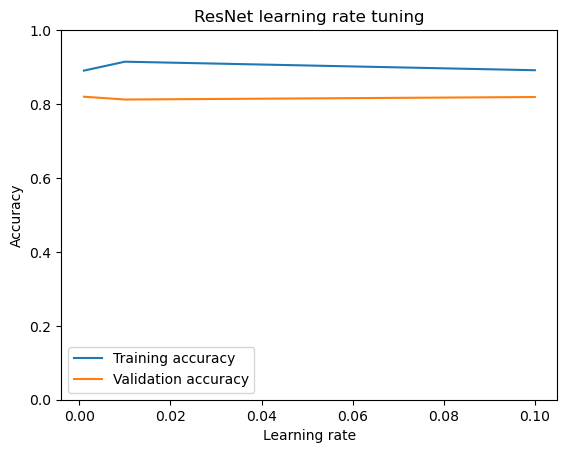

In [12]:
# plot the train-validation accuracy and the learning rate vs accuracy graph
plt.plot(lr_resnet, train_acc_resnet, label='Training accuracy')
plt.plot(lr_resnet, val_acc_resnet, label='Validation accuracy')
plt.xlabel('Learning rate')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.title('ResNet learning rate tuning')
plt.legend()
plt.show()


In [7]:
train_acc_resnet

[0.8904882421174733, 0.914583992407466, 0.8914900347991142]

In [8]:
val_acc_resnet

[0.819831223628692, 0.8122362869198312, 0.8189873417721519]